In [25]:
import scipy.integrate
import scipy.signal
import numpy
%matplotlib notebook
import matplotlib.pyplot

# Mollified Turns

## Overview

At an intersection, a car has to make a smooth turn between two roads. To approximate this, I will attempt to smooth an existing piecewise, not differentiable road intersection using a standard mollifier.

## Defining Mollifier

The standard mollifier is given by the equation

$$ \eta(x) := \begin{cases}
    C \exp \left( \frac{1}{x^2 - 1} \right) & \vert x \vert < 1 \\
    0 & \vert x \vert \geq 1
\end{cases}$$

Where $C > 0$ such that $\int_\mathbb{R} \eta dx = 1$. 

To calculate $C$, we integrate the equation without $C$ in the range $[-1, 1]$ and invert the result. This will ensure the output will be normalized.

In [26]:
C = (scipy.integrate.quad(lambda x: numpy.exp(1 / (x ** 2 - 1)), -1, 1)[0]) ** -1
eta = lambda x: numpy.where(numpy.abs(x) < 1, C * numpy.exp(1 / (x ** 2 - 1)), 0)

Let's plot this to confirm it matches the example provided at https://en.wikipedia.org/wiki/Mollifier.

<IPython.core.display.Javascript object>


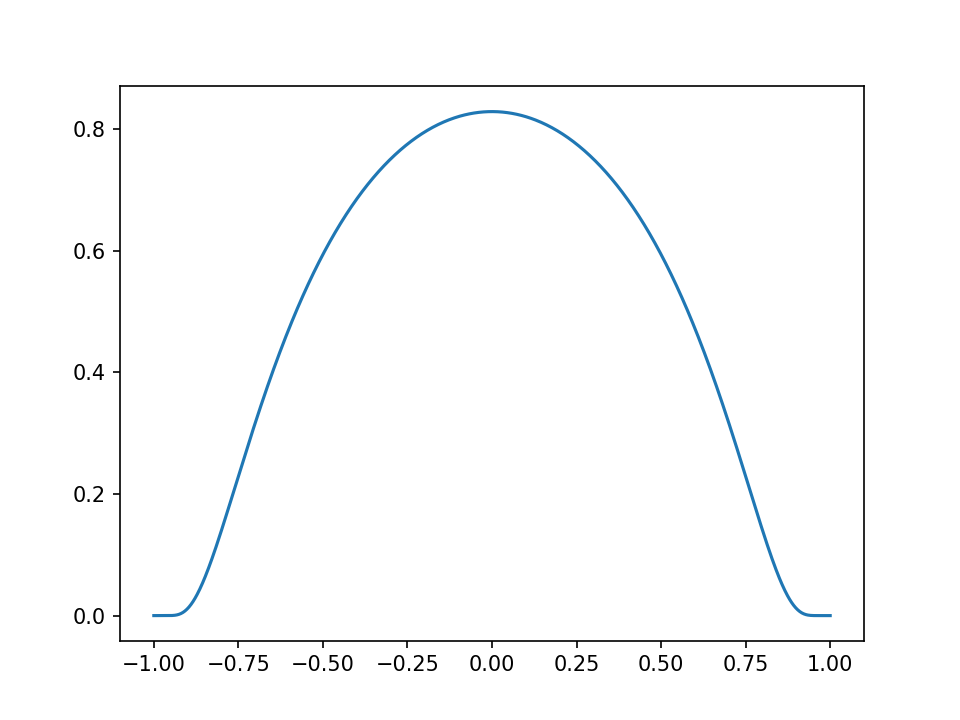

C:\Users\rober\AppData\Local\conda\conda\envs\mlgpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [27]:
fig, ax = matplotlib.pyplot.subplots()
x = numpy.linspace(-1, 1, 1000)
ax.plot(x, eta(x))
matplotlib.pyplot.show()

To have more control over the extent of the smoothing, we can define a set of mollifiers using the equation

$$ \eta_\varepsilon(x) = \frac{1}{\varepsilon} \eta\left(\frac{x}{\varepsilon}\right) $$

In [28]:
eta_epsilon = lambda x, epsilon: numpy.where(numpy.abs(x) < epsilon, C * numpy.exp(1 / ((x / epsilon) ** 2 - 1)) / epsilon, 0)

Let's plot the result to see the effects of the $\varepsilon$ scaling.

<IPython.core.display.Javascript object>


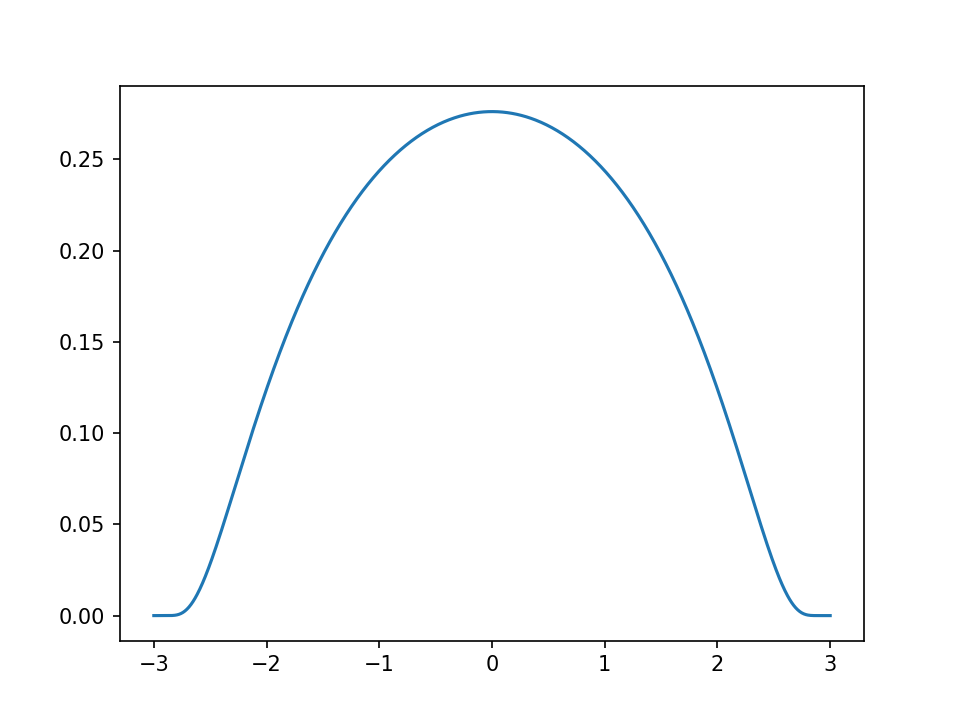

C:\Users\rober\AppData\Local\conda\conda\envs\mlgpu\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [29]:
fig, ax = matplotlib.pyplot.subplots()
epsilon = 3
x = numpy.linspace(-epsilon, epsilon, 1000)
ax.plot(x, eta_epsilon(x, epsilon))
matplotlib.pyplot.show()

## Defining Intersection

We can define an intersection of two roads by using a piecewise function of two linear equations. The general form is given by

$$ f(x) = \begin{cases}
    m_a x + b_a & x < \frac{b_b - b_a}{m_a - m_b} \\
    m_b x + b_b & x \geq \frac{b_b - b_a}{m_a - m_b}
\end{cases} $$

For concreteness, consider the following intersection

$$ f(x) = \begin{cases}
    x + 3 & x < 0 \\
    3 & x \geq 0
\end{cases} $$

In [30]:
f = lambda x: numpy.where(x <= 0, x + 3, 3)

Let's plot the intersection to get an idea of how the turn should look.

<IPython.core.display.Javascript object>


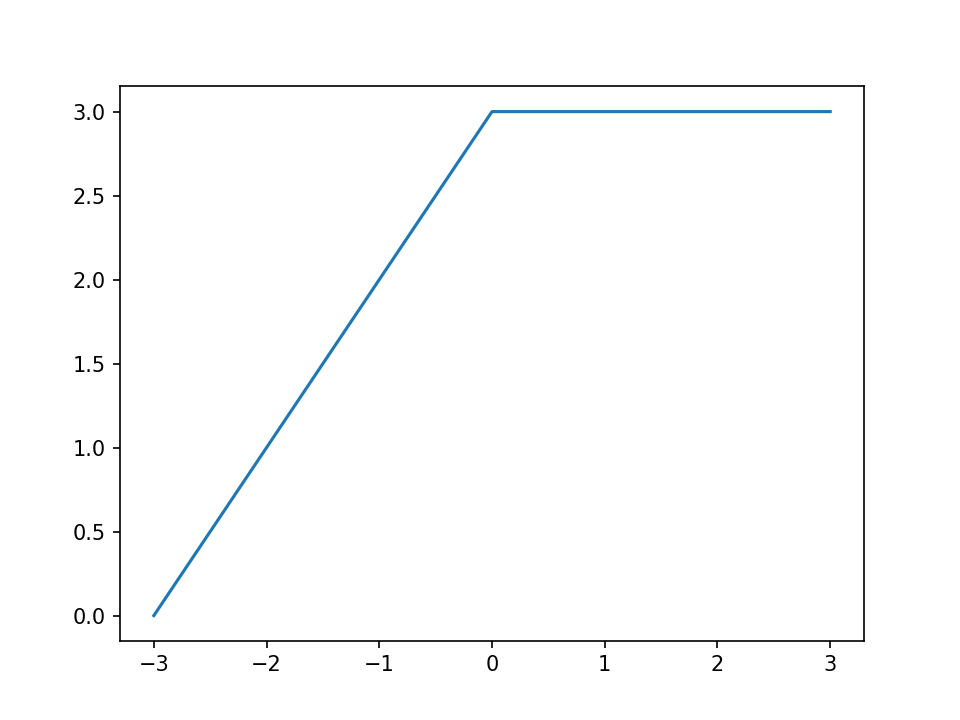

In [31]:
fig, ax = matplotlib.pyplot.subplots()
x = numpy.linspace(-3, 3, 1000)
ax.plot(x, f(x))
matplotlib.pyplot.show()

## Smoothing

Now that we have the intersection and the set of mollifiers, we can try creating the turn. To smooth a function, we convolve the function and a mollifier

$$ f^\varepsilon(x) = \eta_\varepsilon * f = \int \eta_\varepsilon(x - y) f(y) dy $$

Instead of doing this horrible computation ourselves, we can discretize the functions and use NumPy to convolve the two together.

In [32]:
mol = numpy.convolve(eta_epsilon(x, 0.5), f(x), 'same')

Let's plot the result to see how the mollifier smoothed the intersection.

<IPython.core.display.Javascript object>


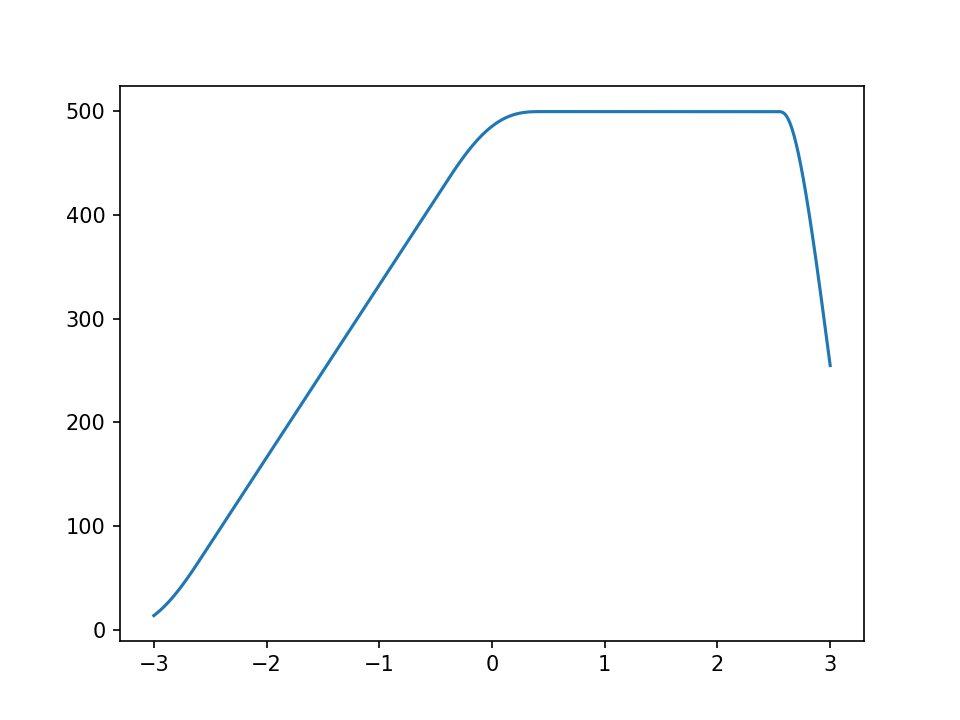

In [34]:
fig, ax = matplotlib.pyplot.subplots()
x = numpy.linspace(-3, 3, 1000)
ax.plot(x, mol)
matplotlib.pyplot.show()

The resulting shape looks quite nice! However, there are some edge effects from the convolution and the range of the function has drastically changed.

## Issues

The scaling and edge effects are not desirable, but that is not the most difficult issue to overcome. In the current set up, $90$-degree turns are not possible unless the intersections are rotated $45$-degrees so there are no vertical lines.

## Conclusion

It may be possible to alter the mollification process to parameterized curves, but I do not have the mathematical ability to do so. Thus, I will not be using this model.